In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from utils.consensus_node import ConsensusNode
from utils.master_node import MasterNode

import wide_resnet_submodule.config as cf
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim

from wide_resnet_submodule.networks import *
from utils.graphs_config import ABC_3
from utils.functions import fit_batch_cifar, update_params_cifar, calc_accuracy_cifar

In [2]:
topology = ABC_3
n_agents = len(topology)

In [3]:
model_name = 'lenet'
num_classes = 10

if model_name == 'lenet':
    model = LeNet
    model_args = [num_classes]
elif model_name == 'vggnet':
    model = VGG
    model_args = [11, num_classes] # VGGnet depth should be either 11, 13, 16, 19
elif model_name == 'resnet':
    model = ResNet
    model_args = [18, num_classes] # Resnet depth should be either 18, 34, 50, 101, 152
elif model_name == 'wide-resnet':
    model = Wide_ResNet
    model_args = [16, 10, 0.3, num_classes] # depth, widen_factor, dropout (Wide-resnet depth should be 6n+4)
else:
    print('Error: Network should be either [LeNet / VGGNet / ResNet / Wide_ResNet', file=sys.stderr)
    exit(0)

criterion = nn.CrossEntropyLoss
learning_rate = 0.02

optimizer = optim.SGD
optimizer_kwargs = {'momentum': 0.9, 'weight_decay': 5e-4}

In [4]:
# Hyper Parameter settings
start_epoch, num_epochs, batch_size, optim_type = cf.start_epoch, cf.num_epochs, cf.batch_size, cf.optim_type

In [5]:
dataset_name = 'cifar10'

In [6]:
# prepare dataset
if dataset_name == 'cifar10':
    
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(cf.mean[dataset_name], cf.std[dataset_name]),
    ]) # meanstd transformation

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(cf.mean[dataset_name], cf.std[dataset_name]),
    ])
    
    trainset = torchvision.datasets.CIFAR10(root='../data/cifar10',
                                            train=True, download=True,
                                            transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='../data/cifar10',
                                           train=False, download=False,
                                           transform=transform_test)
   
    indices = [i for i in range(len(trainset))]
    np.random.shuffle(indices)
    indices = indices[:n_agents*(len(trainset) // n_agents)]
    indices = np.array_split(indices, n_agents)
    subsets = [torch.utils.data.Subset(trainset, indices=ind) for ind in indices]
    train_loaders = {node_name: torch.utils.data.DataLoader(subset,
                                                       batch_size=batch_size,
                                                       shuffle=True,
                                                       num_workers=2)
                for node_name, subset in zip(topology, subsets)
               }
    test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

elif dataset_name == 'titanic':
    def prepare_dataset(df):
        df = df.drop(['Name', 'Ticket', 'Cabin', 'Embarked'], axis=1)
        df['Sex'] = (train_data['Sex'] == 'male').astype(np.int) * 2 - 1
        df = df.fillna({'Age': df['Age'].mean()})
        df['Age'] /= 100
        df['Fare'] /= 100
        df['_bias'] = 1
        if 'Survived' in df.columns:
            return df.drop(['Survived'], axis=1), (df['Survived'] * 2 - 1)
        else:
            return df
    
    train_data = pd.read_csv('../data/titanic/train.csv')
    train_features, train_answers = prepare_dataset(train_data)

    features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', '_bias']
    X = train_features[features].to_numpy()
    y = train_answers.to_numpy()

    common_test_X, common_test_y = X[:X.shape[0] // 10], y[:X.shape[0] // 10]
    X_train, y_train = X[X.shape[0] // 10:], y[X.shape[0] // 10:]
    
    X_train_parts = np.array_split(X_train, n_agents)
    y_train_parts = np.array_split(y_train, n_agents)
    
    train_loaders = {node_name: [(x, y)] for node_name, x, y in zip(topology, X_train_parts, y_train_parts)}
    test_loader = (common_test_X, common_test_y)
else:
    print("This dataset is not yet supported.")
    exit(0)

Files already downloaded and verified


In [7]:
num_epochs = 20

In [8]:
epoch_len = min(len(tl) for tl in train_loaders.values())
print(epoch_len)

131


In [9]:
# init master node
master = MasterNode(node_names=topology.keys(),
                    weights=topology, # param_a = a*param_a + b*param_b + c*param_c, where a + b + c = 1.0
                    train_loaders=train_loaders, # dict of train loaders, train_loaders[node_name] = train loader for node_name
                    test_loader=test_loader, # general test loader
                    fit_step=fit_batch_cifar, # function(node: ConsensusNode, epoch: Int)
                    update_params=update_params_cifar, # function(node: ConsensusNode)
                    calc_accuracy=calc_accuracy_cifar, # function(node: ConsensusNode, test_loader: iterator)
                    stat_step=100, # save statistic each stat step 
                    epoch=num_epochs, # number of epochs
                    epoch_len=epoch_len, # length each epoch
                    update_params_epoch_start=3, # the first epoch from which consensus begins
                    update_params_period=1, # consensus iteration period
                    verbose=2 # verbose mode
                   )

In [10]:
master.set_model(model, *model_args)

Master set model=<class 'wide_resnet_submodule.networks.lenet.LeNet'>, args=(10,), kwargs={}


In [11]:
master.set_optimizer(optimizer, optimizer_kwargs)

Master set optimizer=<class 'torch.optim.sgd.SGD'>, args=({'momentum': 0.9, 'weight_decay': 0.0005},), kwargs={}


In [12]:
master.set_error(criterion)

Master set error=<class 'torch.nn.modules.loss.CrossEntropyLoss'>, args=(), kwargs={}


In [13]:
# init consensus nodes
master.initialize_nodes()

Node Alice set model=LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
) with args=(10,), kwargs={}
Node Alice set optimizer=<class 'torch.optim.sgd.SGD'> with args=({'momentum': 0.9, 'weight_decay': 0.0005},), kwargs={}
Node Alice set error=CrossEntropyLoss() with args=(), kwargs={}
Node Bob set model=LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
) with args=(10,), kwargs={}
Node Bob set optimizer=<class 'torch.optim.sgd.SGD'> with args=({'momentum': 0.9, 'weight_decay': 0

In [14]:
# for pretty outputs uncomment (if warnings)
# import warnings
# warnings.simplefilter(action='ignore', category=Warning)

In [15]:
master.start_consensus()
print('Done!')

Epoch 1:
Node Alice: iter 100, accuracy= 10.49
Node Alice: iter 100, cumulative train loss= 230.08
Node Bob: iter 100, accuracy= 11.51
Node Bob: iter 100, cumulative train loss= 229.26
Node Charlie: iter 100, accuracy= 12.33
Node Charlie: iter 100, cumulative train loss= 229.97
Epoch 1 ended in 26.19 sec

Epoch 2:
Node Alice: iter 200, accuracy= 18.71
Node Alice: iter 200, cumulative train loss= 227.17
Node Bob: iter 200, accuracy= 23.44
Node Bob: iter 200, cumulative train loss= 221.14
Node Charlie: iter 200, accuracy= 20.32
Node Charlie: iter 200, cumulative train loss= 227.79
Epoch 2 ended in 11.67 sec

Epoch 3:
Node Alice: iter 300, accuracy= 19.68
Node Alice: iter 300, cumulative train loss= 220.66
Node Bob: iter 300, accuracy= 19.82
Node Bob: iter 300, cumulative train loss= 214.78
Node Charlie: iter 300, accuracy= 19.91
Node Charlie: iter 300, cumulative train loss= 221.79
Epoch 3 ended in 10.99 sec

Epoch 4:
Node Alice: iter 400, accuracy= 22.04
Node Alice: iter 400, cumulative

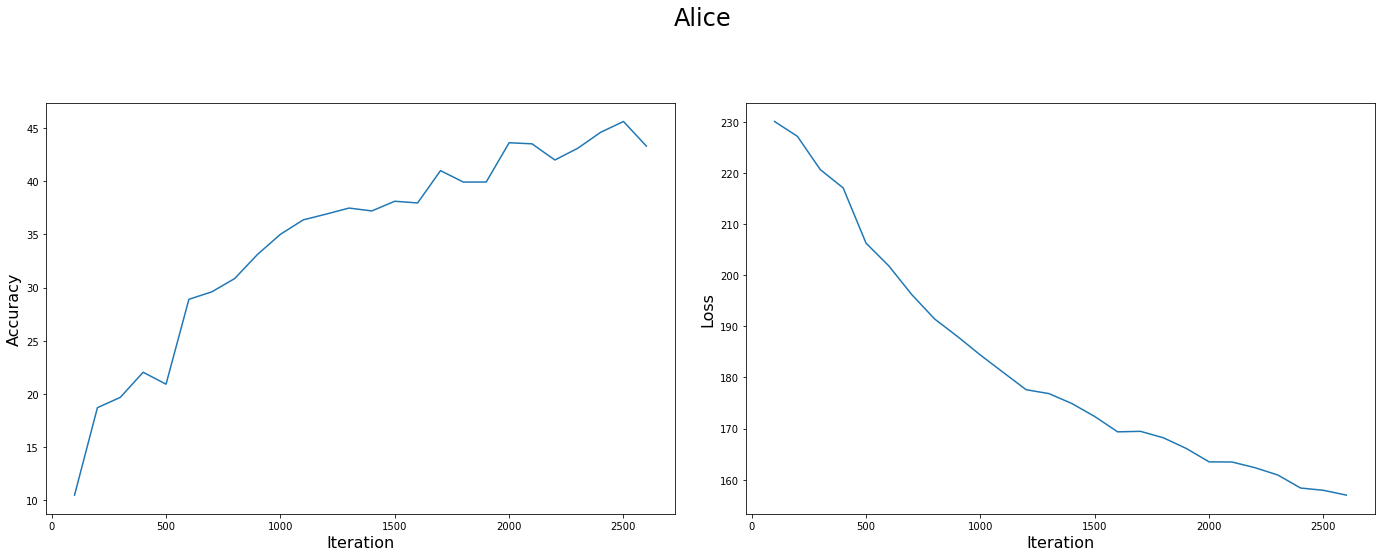

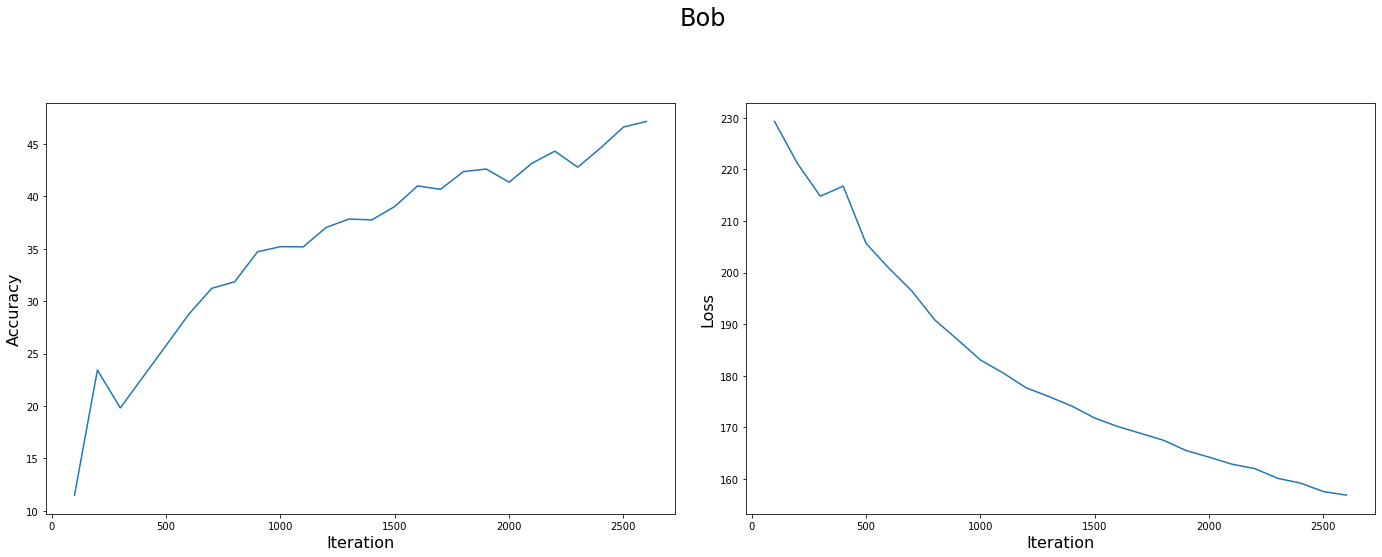

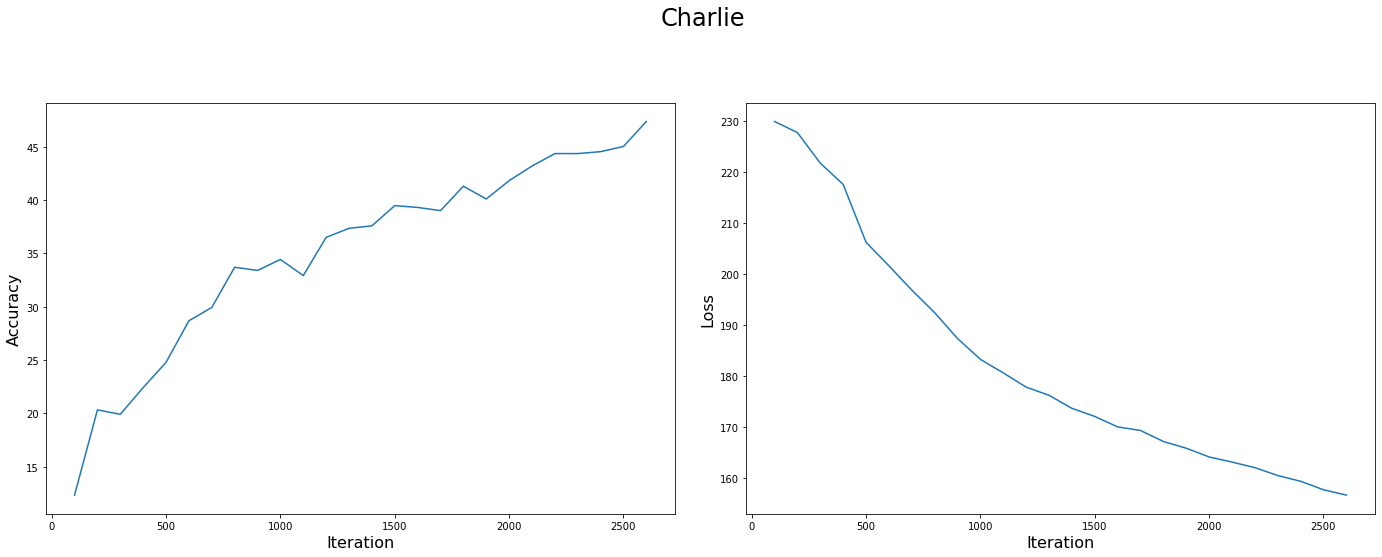

In [16]:
# Accuracy and loss plots for each node
for node in master.network.values():
    node.show_graphs()